In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import os
import cv2
from google.colab.patches import cv2_imshow
import torch.optim as optim
import torch
import torch.nn as nn
import torchvision
from torchvision import models
from torch.utils.data import Dataset, DataLoader
import albumentations as A
import glob
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch.nn.functional as F
from sklearn.metrics import f1_score
import random
# imports the torch_xla package
# import torch_xla
# import torch_xla.core.xla_model as xm

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
# DEVICE = xm.xla_device()
print(DEVICE)

cuda


In [ ]:
IMAGES_COVID = '/content/drive/MyDrive/diploma_project/new/covid/'
IMAGES_NORMAL = '/content/drive/MyDrive/diploma_project/new/normal/'
IMAGES_PNEUMONIA = '/content/drive/MyDrive/diploma_project/new/pneumonia/'
MASKS = '/content/drive/MyDrive/diploma_project/3cl_masks/'
BASE_PATH = '/content/drive/MyDrive/diploma_project/new/'
INFO = BASE_PATH + 'new.csv'

In [ ]:
print(os.path.exists(IMAGES_COVID))
print(os.path.exists(IMAGES_NORMAL))
print(os.path.exists(IMAGES_PNEUMONIA))
print(os.path.exists(MASKS))
print(os.path.exists(BASE_PATH))
print(os.path.exists(INFO))

True
True
True
True
True
True


In [ ]:
NB_CLASSES = 3
EPOCHS = 50
BATCH_SIZE = 6
IMG_SIZE = 1024
PATCH_SIZE = 224

In [ ]:
new_data = pd.DataFrame(columns=['filename', 'type'])

In [ ]:
for f in os.listdir(IMAGES_COVID):
  new_data = new_data.append({'filename': f, 'type': 'covid'}, ignore_index=True)

for f in os.listdir(IMAGES_NORMAL):
  new_data = new_data.append({'filename': f, 'type': 'normal'}, ignore_index=True)

for f in os.listdir(IMAGES_PNEUMONIA):
  new_data = new_data.append({'filename': f, 'type': 'pneumonia'}, ignore_index=True)

In [ ]:
new_data.to_csv(BASE_PATH + 'new.csv')

In [ ]:
def pre_processing(images, flag_jsrt = 0):

    # histogram
    num_out_bit = 256
    num_bin = int(images.max()+1)

    # histogram specification, gamma correction
    hist, bins = np.histogram(images.flatten(), num_bin, [0, num_bin])
    cdf = hist_specification(hist, num_out_bit, int(images.min()), num_bin, flag_jsrt)
    images = cdf[images].astype('float32')

    return images


def hist_specification(hist, bit_output, min_roi, max_roi, flag_jsrt):

    cdf = hist.cumsum()
    cdf = np.ma.masked_equal(cdf, 0)

    # hist sum of low & high
    hist_low = np.sum(hist[:min_roi+1]) + flag_jsrt
    hist_high = int(cdf.max()) - np.sum(hist[max_roi:])

    # cdf mask
    cdf_m = np.ma.masked_outside(cdf, hist_low, hist_high)

    # build cdf_modified
    if not (flag_jsrt):
        cdf_m = (cdf_m - int(cdf_m.min()))*(bit_output-1) / (int(cdf_m.max()) - int(cdf_m.min()))
    else:
        cdf_m = (bit_output-1) - (cdf_m - cdf_m.min())*(bit_output-1) / (cdf_m.max() - cdf_m.min())
    cdf = np.ma.filled(cdf_m.astype('float32'), 0)

    # gamma correction
    cdf = pow(cdf/(bit_output-1), 0.5) * (bit_output-1)

    return cdf

In [ ]:
class XRayDataset(Dataset):
  
  def __init__(self, csv_path, img_dir, mask_dir, augmentation=None):
    self.description = pd.read_csv(csv_path)
    self.img_dir = img_dir
    self.mask_dir = mask_dir
    self.aug_transform = augmentation
    self.filename = '-'

  def __getitem__(self, idx):

    filename = self.description.iloc[idx]['filename']
    self.filename = filename
    img_path = self.img_dir
    label = -1
    if self.description.iloc[idx]['type'] == 'covid':
      img_path = os.path.join(img_path, 'covid')
      label = 2
    elif self.description.iloc[idx]['type'] == 'normal':
      img_path = os.path.join(img_path, 'normal')
      label = 0
    elif self.description.iloc[idx]['type'] == 'pneumonia':
      img_path = os.path.join(img_path, 'pneumonia')
      label = 1

    img = cv2.imread(os.path.join(img_path, filename))
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
    img = pre_processing(img)
    img = img.astype("float32")
    mask = np.load(os.path.join(self.mask_dir, filename + '.npy'))

    mask = np.clip(mask, 0, 1).astype("float32")
    try:
        mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
    except:
        print("mask is None")
        print(filename)

    if mask.max() > 0:
      img[:,:,0] *= mask
      img[:,:,1] *= mask
      img[:,:,2] *= mask

    non_zero_list = np.nonzero(img)

    non_zero_row = random.choice(non_zero_list[0]) # random non-zero row index
    non_zero_col = random.choice(non_zero_list[1]) # random non-zero col index

    img_patch = img[int(max(0, non_zero_row - (PATCH_SIZE / 2))):
                       int(min(IMG_SIZE, non_zero_row + (PATCH_SIZE / 2))),
                       int(max(0, non_zero_col - (PATCH_SIZE / 2))):
                       int(min(IMG_SIZE, non_zero_col + (PATCH_SIZE / 2)))]
    
    if self.aug_transform:
        img_patch = self.aug_transform(image=img_patch)['image']

    return torch.FloatTensor(img_patch), label

  def __len__(self):
    return len(self.description)

In [ ]:
transforms = A.Compose([
    A.Resize(height=PATCH_SIZE, width=PATCH_SIZE, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.4),
    A.Transpose(p=0.4),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        ])

test_transforms = A.Compose([
    A.Resize(height=PATCH_SIZE, width=PATCH_SIZE, p=1.0),
        ])

In [ ]:
data = pd.read_csv(INFO)
data

,Unnamed: 0,filename,type
0,0,COVID-19 (374).jpg,covid
1,1,COVID19(339).jpg,covid
2,2,COVID19(413).jpg,covid
3,3,COVID-19 (304).jpg,covid
4,4,COVID19(52).jpg,covid
...,...,...,...
6934,6934,person80_virus_150.jpeg,pneumonia
6935,6935,person918_virus_1575.jpeg,pneumonia
6936,6936,person906_bacteria_2831.jpeg,pneumonia
6937,6937,person844_virus_1487.jpeg,pneumonia


In [ ]:
train_val_df, test_df = train_test_split(data, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.125, random_state=41)
len(train_df), len(val_df), len(test_df)

(4857, 694, 1388)

In [ ]:
def count_classes_parts(df):
  c = len(df[df['type'] == 'covid'])
  n = len(df[df['type'] == 'normal'])
  p = len(df[df['type'] == 'pneumonia'])
  all = len(df)
  print('c\tn\tp')
  print(c, n, p, sep='\t')
  print("{:.2f}".format(c / all), "{:.2f}".format(n / all), "{:.2f}".format(p / all), sep='\t')

print('train:')
count_classes_parts(train_df)
print('val:')
count_classes_parts(val_df)
print('test')
count_classes_parts(test_df)

train:
c	n	p
1594	1619	1644
0.33	0.33	0.34
val:
c	n	p
239	233	222
0.34	0.34	0.32
test
c	n	p
480	461	447
0.35	0.33	0.32


In [ ]:
train_df.to_csv(BASE_PATH + 'train.csv')
val_df.to_csv(BASE_PATH + 'val.csv')
test_df.to_csv(BASE_PATH + 'test.csv')

In [ ]:
train_df = pd.read_csv(BASE_PATH + 'train.csv')
val_df = pd.read_csv(BASE_PATH + 'val.csv')
test_df = pd.read_csv(BASE_PATH + 'test.csv')

In [ ]:
# train
train_dataset = XRayDataset(csv_path=BASE_PATH + 'train.csv', img_dir=BASE_PATH, 
                             mask_dir=MASKS, augmentation=transforms)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=4, 
                              shuffle=True)

# validation
val_dataset = XRayDataset(csv_path=BASE_PATH + 'val.csv', img_dir=BASE_PATH,
                             mask_dir=MASKS, augmentation=transforms)

val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=4, 
                            shuffle=True)

# test
test_dataset = XRayDataset(csv_path=BASE_PATH + 'test.csv', img_dir=BASE_PATH, 
                             mask_dir=MASKS,  augmentation=test_transforms)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=4, 
                             shuffle=False)

In [ ]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, NB_CLASSES),
    nn.Sigmoid())
model.to(DEVICE)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
def train_one_epoch(model, optimizer, lr_scheduler, metric,
                    dataloader, epoch, criterion):
    
    print("Start Train ...")
    model.train()

    losses = []

    y_score = []
    y_true = []
    y_pred = []
    corrects = 0

    for data, target in dataloader:

        data = data.permute(0,3,1,2).to(DEVICE)
        targets = target.unsqueeze(1).to(DEVICE)
        targets_np = np.asarray(targets.cpu())

        outputs = model(data)
        out_cut = np.copy(outputs.data.cpu().numpy())

        target = target.to(DEVICE)
        loss = criterion(outputs, target)
        l1_regularization = torch.tensor(0).to(DEVICE, dtype=float)
        for param in model.parameters():
            l1_regularization += torch.norm(param, 1)
        loss += (1e-5 * l1_regularization)
        losses.append(loss.item())

        # metrics
        _, preds = torch.max(outputs, 1)
        corrects += torch.sum(preds == target.data)
        pred_np = np.asarray(preds.cpu())

        for i in range(len(data)):
          y_score.append(out_cut[i][1])

        for i in range(len(targets)):
          y_true.append(targets_np[i])

        for i in range(len(data)):
          y_pred.append(pred_np[i])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if lr_scheduler is not None:
        lr_scheduler.step()

    lr = lr_scheduler.get_last_lr()[0]

    epoch_acc = corrects.double() / len(dataloader.dataset)
    epoch_f1 = metric(y_true, y_pred, average='macro')

    print("Epoch [%d]" % (epoch),
          "Mean loss on train:", np.array(losses).mean(), 
          "Mean accuracy on train: %.4f" %epoch_acc,
          "Mean F1 score on train: %.4f" %epoch_f1, 
          "Learning Rate:", lr)

    return np.array(losses).mean(), epoch_acc, epoch_f1, lr


def val_epoch(model, metric, dataloader, epoch, threshold=0.5):
    
    print("Start Validation ...")
    model.eval()
    
    y_score = []
    y_true = []
    y_pred = []
    corrects = 0

    with torch.no_grad():
        for data, target in dataloader:
            data = data.permute(0,3,1,2).to(DEVICE)
            targets = target.unsqueeze(1).to(DEVICE)
            targets_np = np.asarray(targets.cpu())

            outputs = model(data)
            out_cut = np.copy(outputs.data.cpu().numpy())

            # metrics
            target = target.to(DEVICE)
            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == target.data)
            pred_np = np.asarray(preds.cpu())

            for i in range(len(data)):
              y_score.append(out_cut[i][1])

            for i in range(len(targets)):
              y_true.append(targets_np[i])

            for i in range(len(data)):
              y_pred.append(pred_np[i])
            
        epoch_acc = corrects.double() / len(dataloader.dataset)
        epoch_f1 = metric(y_true, y_pred, average='macro')

        print("Epoch [%d]" % (epoch),  "Threshold:", threshold, 
          "Mean Validation Accuracy: %.4f" %epoch_acc,
          "Mean Validation F1 score: %.4f" %epoch_f1)

        return epoch_acc, epoch_f1

In [ ]:
# for param in model.parameters():
#     param.requires_grad = False
    
params = [p for p in model.parameters() if p.requires_grad]

num_epochs = 50
optimizer = optim.Adam(params, lr=1e-5, weight_decay=0.1)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)
criterion = nn.CrossEntropyLoss()

loss_history = []
train_acc_history = []
train_f1_history = []
val_acc_history = []
val_f1_history = []
lr_history = []

for epoch in range(num_epochs):

        loss, train_acc, train_f1, lr = train_one_epoch(model, optimizer, lr_scheduler, 
                                             f1_score, train_dataloader, epoch, criterion)
    
        val_acc, val_f1 = val_epoch(model, f1_score, val_dataloader, epoch)
        
        
        # train history
        loss_history.append(loss)
        train_acc_history.append(train_acc)
        train_f1_history.append(train_f1)
        lr_history.append(lr)
        val_acc_history.append(val_acc)
        val_f1_history.append(val_f1)

        # save best weights
        best_acc = max(val_acc_history)
        if val_acc >= best_acc:
            torch.save({'last_state_dict': model.state_dict()},
                        os.path.join(BASE_PATH + 'weights_seg_patch_2/', f"{val_acc:0.6f}_.pth"))
            
print(loss_history)
print(train_acc_history)
print(train_f1_history)
print(val_acc_history)
print(val_f1_history)
print(lr_history)

Start Train ...
Epoch [0] Mean loss on train: 2.3920029465063117 Mean accuracy on train: 0.5545 Mean F1 score on train: 0.5443 Learning Rate: 1e-05
Start Validation ...
Epoch [0] Threshold: 0.5 Mean Validation Accuracy: 0.7594 Mean Validation F1 score: 0.7586
Start Train ...
Epoch [1] Mean loss on train: 1.7836857312991294 Mean accuracy on train: 0.7212 Mean F1 score on train: 0.7200 Learning Rate: 1e-05
Start Validation ...
Epoch [1] Threshold: 0.5 Mean Validation Accuracy: 0.8098 Mean Validation F1 score: 0.8096
Start Train ...
Epoch [2] Mean loss on train: 1.44685169811602 Mean accuracy on train: 0.7509 Mean F1 score on train: 0.7501 Learning Rate: 1e-05
Start Validation ...
Epoch [2] Threshold: 0.5 Mean Validation Accuracy: 0.8689 Mean Validation F1 score: 0.8687
Start Train ...
Epoch [3] Mean loss on train: 1.2431622909910884 Mean accuracy on train: 0.7692 Mean F1 score on train: 0.7685 Learning Rate: 1e-05
Start Validation ...
Epoch [3] Threshold: 0.5 Mean Validation Accuracy: 0.

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe263477b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe263477b00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch [48] Mean loss on train: 0.7394972417825534 Mean accuracy on train: 0.8538 Mean F1 score on train: 0.8531 Learning Rate: 1e-05
Start Validation ...
Epoch [48] Threshold: 0.5 Mean Validation Accuracy: 0.8559 Mean Validation F1 score: 0.8547
Start Train ...


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe263477b00>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe263477b00>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
    if w.is_alive():
  File "/usr/lib/pytho

Epoch [49] Mean loss on train: 0.7433249834143085 Mean accuracy on train: 0.8518 Mean F1 score on train: 0.8513 Learning Rate: 1e-05
Start Validation ...
Epoch [49] Threshold: 0.5 Mean Validation Accuracy: 0.8862 Mean Validation F1 score: 0.8848
[2.3920029465063117, 1.7836857312991294, 1.44685169811602, 1.2431622909910884, 1.1216110807878, 1.0426779721254185, 0.988605436940252, 0.9404140664471521, 0.9238933306417347, 0.9024430938708929, 0.8808783478207058, 0.8694049936753733, 0.8492649917985187, 0.8450909497561279, 0.8346277952930073, 0.8171832080240603, 0.8139976304254414, 0.8063645832332564, 0.8108513250027174, 0.7983666024090331, 0.7989620784182607, 0.782177014189002, 0.7905173749099543, 0.7839326740782938, 0.7813010351157482, 0.7790834061157557, 0.7721927937166191, 0.7721179986441576, 0.7729941295252906, 0.7725381088845524, 0.768959402596509, 0.7678896404342886, 0.7658771148434391, 0.7609194639288349, 0.7591991890359808, 0.7615755685317663, 0.7558310415273831, 0.7420855000431155, 0

In [ ]:
# for param in model.parameters():
#     param.requires_grad = False
    
# params = [p for p in model.parameters() if p.requires_grad]

# num_epochs = 50
# optimizer = optim.Adam(params, lr=1e-5, weight_decay=0.1)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)
# criterion = nn.CrossEntropyLoss()

# loss_history = []
# train_acc_history = []
# train_f1_history = []
# val_acc_history = []
# val_f1_history = []
# lr_history = []

for epoch in range(50, 100):

        loss, train_acc, train_f1, lr = train_one_epoch(model, optimizer, lr_scheduler, 
                                             f1_score, train_dataloader, epoch, criterion)
    
        val_acc, val_f1 = val_epoch(model, f1_score, val_dataloader, epoch)
        
        
        # train history
        loss_history.append(loss)
        train_acc_history.append(train_acc)
        train_f1_history.append(train_f1)
        lr_history.append(lr)
        val_acc_history.append(val_acc)
        val_f1_history.append(val_f1)

        # save best weights
        best_acc = max(val_acc_history)
        if val_acc >= best_acc:
            torch.save({'last_state_dict': model.state_dict()},
                        os.path.join(BASE_PATH + 'weights_seg_patch_2/', f"{val_acc:0.6f}_.pth"))
            
print(loss_history)
print(train_acc_history)
print(train_f1_history)
print(val_acc_history)
print(val_f1_history)
print(lr_history)

Start Train ...
Epoch [50] Mean loss on train: 0.7396413996631717 Mean accuracy on train: 0.8567 Mean F1 score on train: 0.8560 Learning Rate: 1e-05
Start Validation ...
Epoch [50] Threshold: 0.5 Mean Validation Accuracy: 0.9020 Mean Validation F1 score: 0.9013
Start Train ...
Epoch [51] Mean loss on train: 0.7348870871979514 Mean accuracy on train: 0.8627 Mean F1 score on train: 0.8622 Learning Rate: 1e-05
Start Validation ...
Epoch [51] Threshold: 0.5 Mean Validation Accuracy: 0.9150 Mean Validation F1 score: 0.9147
Start Train ...
Epoch [52] Mean loss on train: 0.7352394538897055 Mean accuracy on train: 0.8575 Mean F1 score on train: 0.8570 Learning Rate: 1e-05
Start Validation ...
Epoch [52] Threshold: 0.5 Mean Validation Accuracy: 0.8905 Mean Validation F1 score: 0.8903
Start Train ...
Epoch [53] Mean loss on train: 0.7338532505212007 Mean accuracy on train: 0.8594 Mean F1 score on train: 0.8588 Learning Rate: 1e-05
Start Validation ...
Epoch [53] Threshold: 0.5 Mean Validation Ac

### EVALUATING

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import itertools

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Upload model best state

In [ ]:
len(test_dataloader.dataset)

1388

In [ ]:
weights_dir = BASE_PATH + 'weights_seg_patch_2/'
# Load the best weights
best_weights =  sorted(glob.glob(weights_dir + "/*"),
                    key= lambda x: x[8:-5])[-1]
checkpoint = torch.load(best_weights)
model.load_state_dict(checkpoint['last_state_dict'])

print(f'Loaded model: {best_weights.split("/")[-1]}')

Loaded model: 0.927954_.pth


In [ ]:
small_test_df = test_df.iloc[-6:]
small_test_df

,Unnamed: 0,Unnamed: 0.1,filename,type
1382,5516,5516,person296_bacteria_1395.jpeg,pneumonia
1383,652,652,618.png,covid
1384,33,33,COVID-19 (774).jpg,covid
1385,4988,4988,person1067_bacteria_3001.jpeg,pneumonia
1386,44,44,COVID19(462).jpg,covid
1387,3307,3307,00001101_013.png,normal


In [ ]:
small_test_df.to_csv(BASE_PATH + 'small.csv')

In [ ]:
small_dataset = XRayDataset(csv_path=BASE_PATH + 'small.csv', img_dir=BASE_PATH, mask_dir=MASKS, augmentation=test_transforms)
small_dataloader = DataLoader(small_dataset, batch_size=2, num_workers=4)

Start testing
[array([0]), array([1]), array([1]), array([0]), array([1]), array([1]), array([2]), array([2]), array([1]), array([0]), array([0]), array([1]), array([0]), array([2]), array([2]), array([0]), array([1]), array([0]), array([0]), array([0]), array([1]), array([1]), array([2]), array([2]), array([2]), array([2]), array([1]), array([0]), array([0]), array([1]), array([1]), array([1]), array([2]), array([1]), array([0]), array([1]), array([0]), array([2]), array([2]), array([1]), array([1]), array([1]), array([2]), array([0]), array([2]), array([1]), array([2]), array([1]), array([2]), array([2]), array([1]), array([2]), array([1]), array([1]), array([1]), array([2]), array([0]), array([0]), array([1]), array([0]), array([0]), array([2]), array([1]), array([2]), array([2]), array([2]), array([0]), array([2]), array([0]), array([0]), array([0]), array([2]), array([1]), array([0]), array([1]), array([2]), array([1]), array([2]), array([2]), array([0]), array([1]), array([2]), a

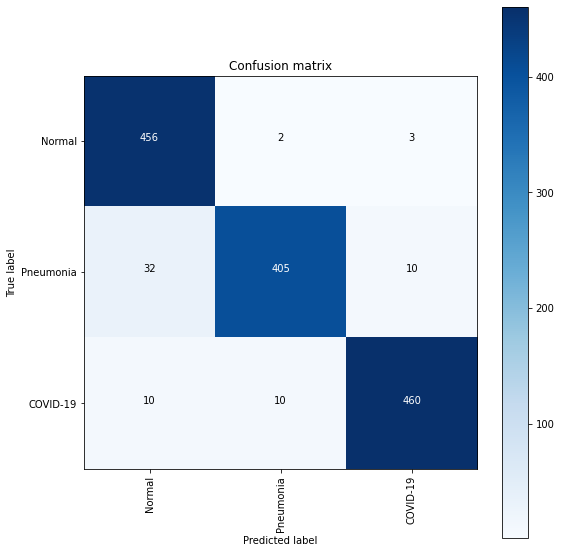

<Figure size 432x288 with 0 Axes>

In [ ]:
print('Start testing')
model.eval()

patches_amount = 100
test_len = len(test_dataloader.dataset)
y_true = []
y_pred_patch = []
for i in range(test_len):
  y_pred_patch.append([])

assert len(y_pred_patch) == test_len

for iter in range(patches_amount):
    test_idx = 0
    for data, target in test_dataloader:
        data = data.permute(0,3,1,2).to(DEVICE)
        targets = target.unsqueeze(1).to(DEVICE)
        target = target.to(DEVICE)
        targets_np = np.asarray(targets.cpu())

        outputs = model(data)
        out_cut = np.copy(outputs.data.cpu().numpy())

        # metrics
        _, preds = torch.max(outputs, 1)
        # corrects += torch.sum(preds == target.data)
        pred_np = np.asarray(preds.cpu())

        if iter == 0:
          for x in targets_np:
            y_true.append(x)

        for x in range(len(data)):
          y_pred_patch[test_idx].append(pred_np[x])
          test_idx += 1

        
y_pred = []
for i in range(test_len):
  y_pred.append(np.bincount(y_pred_patch[i]).argmax())

print(y_true)
print(y_pred)

# Overall classification report
print(classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia', 'COVID-19']))
ACC = accuracy_score(y_true, y_pred)
PREC = precision_score(y_true, y_pred, average='macro')
REC = recall_score(y_true, y_pred, average='macro')
F1 = f1_score(y_true, y_pred, average='macro')

print('Accuracy: {:.4f} Precision: {:.4f} Recall: {:.4f} F1: {:.4f}'.format(ACC, PREC, REC, F1))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 8))
plt.grid(b=False)
plot_confusion_matrix(cm, classes=['Normal', 'Pneumonia', 'COVID-19'], normalize=False,
                      title='Confusion matrix', cmap=plt.cm.Blues)
plt.show()
plt.savefig(BASE_PATH + 'confmatrix_test.png')



Plots

No handles with labels found to put in legend.


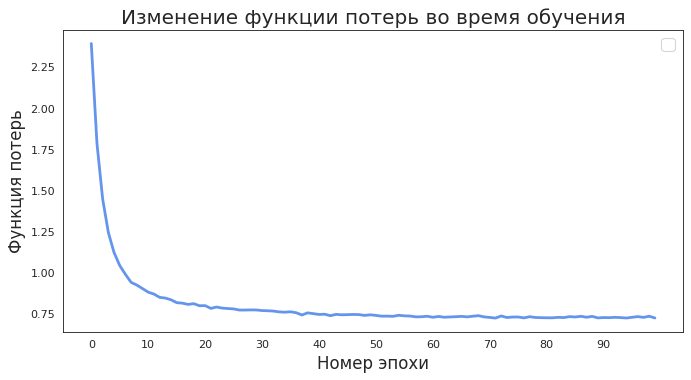

In [ ]:
# train dice
sns.set_style("white")
fig = plt.figure(figsize=(10, 5), dpi=80)
plt.plot(np.arange(100), loss_history, color="cornflowerblue", linewidth=2.5, linestyle="-")

plt.xticks(np.arange(0, 100, 10))

plt.ylabel("Функция потерь", fontsize=15)
plt.xlabel("Номер эпохи", fontsize=15)
plt.title("Изменение функции потерь во время обучения", fontsize=18)
plt.legend(fontsize=15);

plt.show()

fig.savefig(BASE_PATH + 'loss.png')

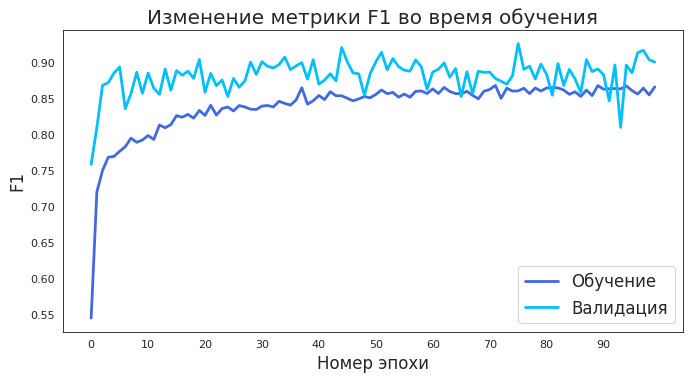

In [ ]:
# train dice
sns.set_style("white")
fig = plt.figure(figsize=(10, 5), dpi=80)
plt.plot(np.arange(100), train_f1, color="royalblue", linewidth=2.5, linestyle="-")
plt.plot(np.arange(100), val_f1, color="deepskyblue", linewidth=2.5, linestyle="-")

plt.xticks(np.arange(0, 100, 10))
#plt.yticks(np.linspace(0.75, 1, 11))

plt.ylabel("F1", fontsize=15)
plt.xlabel("Номер эпохи", fontsize=15)
plt.title("Изменение метрики F1 во время обучения", fontsize=18)
plt.legend(['Обучение', 'Валидация'], fontsize=15);

plt.show()

fig.savefig(BASE_PATH + 'f1.png')